# **Concept Similarity**

In [278]:
import pandas as pd
from nltk.corpus import wordnet as wn
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## Wu & Palmer Similarity

In [3]:
# Depth of a synset - number of steps from the synset to the root
def depth(s):
    if s is None:
        return -1
    hypernyms = s.hypernyms()
    if len(hypernyms) == 0:
        return 0
    else:
        return 1 + max([depth(h) for h in hypernyms]) # add 1 to get the last step to the synset s

# Get all hypernyms of a synset (including itself)
def all_hypernyms(s):
    hypernyms = [s]
    for h in s.hypernyms():
        hypernyms.extend(all_hypernyms(h))
    return hypernyms

# Lowest Common Subsumer
def lcs(s1, s2):
    hyper1 = all_hypernyms(s1)
    hyper2 = all_hypernyms(s2)
    if len(hyper1) == 0 or len(hyper2) == 0:
        return None
    candidates = set(hyper1).intersection(set(hyper2))
    if len(candidates) > 0:
        return max(candidates, key=depth)
    else:
        return None

# Wu and Palmer similarity
def wup_sim(s1, s2):
    lcs_syn = lcs(s1, s2)
    if lcs_syn is None:
        return 0
    return 2 * depth(lcs_syn) / (depth(s1) + depth(s2))

## Shortest Path Similarity

In [4]:
# Find max depth of all synsets in wordnet
def max_depth():
    max = 0
    for synset in wn.all_synsets():
        d = depth(synset)
        if d > max:
            max = d
    return max

# max_depth = max_depth() it is always 19, so we can hardcode it
max_depth = 19

In [5]:
# Find shortest path between two synsets
def shortest_path(s1, s2):
    lcs_syn = lcs(s1, s2)
    if lcs_syn is None:
        return max_depth
    return depth(s1) + depth(s2) - 2 * depth(lcs_syn)

# Shortest path similarity
def short_path_sim(s1, s2):
    return 2 * max_depth - shortest_path(s1, s2)

## Leacock & Chodorow Similarity

In [6]:
# Leacock and Chodorow similarity
def leac_sim(s1, s2):
    distance = shortest_path(s1, s2)
    if distance == 0:
        return -np.log(distance + 1 / (2 * max_depth + 1))
    return -np.log(distance / (2 * max_depth))

Dato che l'input in WordSim353 è una coppia di termini, mentre le tre formule utilizzano sensi, per calcolare la similarity fra i 2 termini prendiamo la massima similarity fra tutti i sensi del primo termine e tutti i sensi del secondo termine.

In [7]:
# Get max similarity between all synsets of two words, given a similarity function
def get_max_similarity(s1, s2, sim_func):
    s1_synsets = wn.synsets(s1)
    s2_synsets = wn.synsets(s2)
    max_sim = 0
    # best_s1 = None
    # best_s2 = None
    for s1_syn in s1_synsets:
        for s2_syn in s2_synsets:
            sim = sim_func(s1_syn, s2_syn)
            if sim > max_sim:
                max_sim = sim
                # best_s1 = s1_syn
                # best_s2 = s2_syn
    return max_sim

In [8]:
# Load the data
df = pd.read_csv('/Users/jak/Documents/Uni/TLN/TLN /Radicioni/data/WordSim353.csv')

Compute similarities for WordSim353 and print results

In [9]:
# Compute the three similarity measures
df['wup'] = df.apply(lambda row: get_max_similarity(row['Word 1'], row['Word 2'], wup_sim), axis=1)
df['shortest'] = df.apply(lambda row: get_max_similarity(row['Word 1'], row['Word 2'], short_path_sim), axis=1)
df['leacock'] = df.apply(lambda row: get_max_similarity(row['Word 1'], row['Word 2'], leac_sim), axis=1)

# Show the dataframe
print(df.head(10))

# Results for Wu and Palmer similarity
print('\nWu and Palmer similarity results')
spearman = stats.spearmanr(df['Human (mean)'], df['wup'])
print(f'Spearman correlation: {spearman[0]}, p-value: {spearman[1]}')
pearson = stats.pearsonr(df['Human (mean)'], df['wup'])
print(f'Pearson correlation: {pearson[0]}, p-value: {pearson[1]}')

print('--------------------------------')

# Results for Shortest Path similarity
print('Shortest Path similarity results')
spearman = stats.spearmanr(df['Human (mean)'], df['shortest'])
print(f'Spearman correlation: {spearman[0]}, p-value: {spearman[1]}')
pearson = stats.pearsonr(df['Human (mean)'], df['shortest'])
print(f'Pearson correlation: {pearson[0]}, p-value: {pearson[1]}')

print('--------------------------------')

# Results for Leacock and Chodorow similarity
print('Leacock and Chodorow similarity results')
spearman = stats.spearmanr(df['Human (mean)'], df['leacock'])
print(f'Spearman correlation: {spearman[0]}, p-value: {spearman[1]}')
pearson = stats.pearsonr(df['Human (mean)'], df['leacock'])
print(f'Pearson correlation: {pearson[0]}, p-value: {pearson[1]}')

       Word 1         Word 2  Human (mean)       wup  shortest   leacock
0        love            sex          6.77  0.909091        37  3.637586
1       tiger            cat          7.35  0.962963        37  3.637586
2       tiger          tiger         10.00  1.000000        38  3.663562
3        book          paper          7.46  0.857143        36  2.944439
4    computer       keyboard          7.62  0.800000        35  2.538974
5    computer       internet          7.58  0.588235        31  1.691676
6       plane            car          5.77  0.700000        32  1.845827
7       train            car          6.31  0.705882        33  2.028148
8   telephone  communication          7.50  0.000000        28  1.335001
9  television          radio          6.77  0.900000        36  2.944439

Wu and Palmer similarity results
Spearman correlation: 0.32205979107230365, p-value: 5.816296751820106e-10
Pearson correlation: 0.2756318557372003, p-value: 1.4205427728723012e-07
----------------

# **Word Sense Disambiguation**

## Lesk Algorithm implementation

In [10]:
import re

In [292]:
# Remove stop words and punctuation from a given sentence
def remove_stop_punct(sentence):
    stop_words = []
    with open('/Users/jak/Documents/Uni/TLN/TLN /Radicioni/data/stop_words_FULL.txt', 'r') as f:
        for line in f:
            stop_words.append(line.strip())
    punct = set(['.', ',', '!', '?', ':', ';', '(', ')', '[', ']', '{', '}', '"', "'", '``', "''", '...', '’', '“', '”', '—', '–', '‘', '—'])
    sentence = [w for w in sentence if not w in stop_words and not w in punct]
    return sentence

# Get content words for the context
def get_context(sentence):
    # convert sentence to string
    sentence = ''.join(sentence)
    # sentence = [w.lower() for w in sentence]
    sentence = set(sentence.lower().split())
    # lower case
    sentence = remove_stop_punct(sentence)
    return sentence

# Get content words for the signature
def get_signature(synset):
    signature = set(synset.definition().lower().split())
    for example in synset.examples():
        signature.update(example.lower().split())
    signature = remove_stop_punct(signature)
    return signature
    
# Lesk algorithm - using bag of words approach
def lesk(word, sentence):
    best_sense = wn.synsets(word)[0]
    # print(f'Starting with sense: {best_sense}')
    max_overlap = 0
    context = get_context(sentence)
    for synset in wn.synsets(word):
        signature = get_signature(synset)
        overlap = [w for w in context if w in signature]
        if len(overlap) > max_overlap:
            max_overlap = len(overlap)
            best_sense = synset
            # print(f'New best sense for {word}: {best_sense}')
            # print(f'Signature: {signature}')
            # print(f'Context: {context}')
            # print(f'Overlap: {overlap}')
    return best_sense

In [12]:
# Try the algorithm on the file sentences.txt
with open('/Users/jak/Documents/Uni/TLN/TLN /Radicioni/data/sentences.txt', 'r') as f:
    for i, line in enumerate(f):
        if i > 2 and i < 17:
            line = line.strip()[2:-1]
            # find word between **
            word = re.search(r'\*\*(.*?)\*\*', line).group(1)
            sentence = line.replace(f'**{word}**', word)
            sense = lesk(word, sentence)
            print(f'Word: {word}')
            print(f'Sentence: {sentence}')
            print(f'Best sense: {sense, sense.definition()}')
            print('--------------------------------')

Word: Arms
Sentence: Arms bend at the elbow
Best sense: (Synset('arm.n.01'), 'a human limb; technically the part of the superior limb between the shoulder and the elbow but commonly used to refer to the whole superior limb')
--------------------------------
Word: arms
Sentence: Germany sells arms to Saudi Arabia
Best sense: (Synset('arm.v.02'), 'supply with arms')
--------------------------------
Word: key
Sentence: The key broke in the lock
Best sense: (Synset('key.n.01'), "metal device shaped in such a way that when it is inserted into the appropriate lock the lock's mechanism can be rotated")
--------------------------------
Word: key
Sentence: The key problem was not one of quality but of quantity
Best sense: (Synset('key.n.02'), 'something crucial for explaining')
--------------------------------
Word: solution
Sentence: Work out the solution in your head
Best sense: (Synset('solution.n.01'), 'a homogeneous mixture of two or more substances; frequently (but not necessarily) a liqu

## Working with SemCor

In [13]:
from nltk.corpus import semcor
import random

Get all sentences from SemCor corpus

In [258]:
sentences = semcor.sents()
tagged_sentences = semcor.tagged_sents(tag='both') # tag='both' to get both the POS tag and the synset from the gold corpus, in orderd to compare with the results of my algorithm

# Get the total number of sentences in the corpus so that we don't need to compute it every time
total = len(sentences)
print(f'Total number of sentences: {total}')

Total number of sentences: 37176


Functions to choose a noun and a synset from a sentence

In [290]:
# Get noun and corresponding synset from a tagged element
def get_noun(tagged):
    tmp = str(tagged).split('(NN ')
    noun = tmp[1][:-2]
    tmp = tmp[0].split('Lemma(')
    synset = tmp[1][1:-3]
    return noun, synset

# Choose the first (a random) noun given a tagged sentence
def choose_noun(tagged_sentence):
    noun = None
    synset = None
    for i in range(len(tagged_sentence)):
        sent = str(tagged_sentence[i])
        # Choose the noun only if it is properly tagged (even with the corresponding synset)
        if 'Lemma' in sent and 'NN ' in sent:
            noun, synset = get_noun(tagged_sentence[i])
            break
        # if i == len(tagged_sentence) - 1:
            # print('No noun properly tagged in this sentence')
    return noun, synset

Extract the sentences

In [291]:
# Extract the first 50 sentences from the corpus
first_50_sents = sentences[:50]
first_50_tagged = tagged_sentences[:50]

# Extract the 50 sentences and tagged sentences at random from the corpus
def get_random_sents():
    random_sents = []
    random_tagged = []
    while len(random_sents) < 50:
        random_index = random.randint(0, total)
        noun = choose_noun(tagged_sentences[random_index])[0]
        # Add the sentence only if it contains a noun properly tagged, otherwise I cannot compare the results of my algorithm with the gold corpus
        if noun is not None:
            random_sents.append(sentences[random_index])
            random_tagged.append(tagged_sentences[random_index])
    return random_sents, random_tagged

random_sents, random_tagged = get_random_sents()

# print(random_tagged[0])
# noun, synset = choose_noun(random_tagged[0])
# print(f'Chosen noun: {noun}')
# print(f'Chosen synset: {synset}')
# for i in range(len(random_tagged)):
#     print(random_tagged[i])
#     print('-'*50)
# print(f'Number of sentences: {len(random_sents)}')

Compare the results with the synsets in the corpus

In [289]:
# Compare the accuracy of my algorithm with the synsets from the gold corpus
def compare_accuracy(sentences, tagged_sentences):
    correct = 0
    total = 0
    for i in range(len(tagged_sentences)):
        noun, synset = choose_noun(tagged_sentences[i])
        # print(f'Chosen noun: {noun}')
        # print(f'Chosen synset: {synset}')
        noun = noun.replace(' ', '_')
        noun = noun.replace('.', '')
        if noun is not None:
            total += 1
            sentence = sentences[i]
            try:
                sense = lesk(noun, sentence)
            except IndexError: # if the word is not in WordNet
                print(f'Error with word {noun}')
                # print(f'Synset: {synset}')
                # print(f'Sentence: {tagged_sentences[i]}')
                continue
            # print(f'Found sense: {sense}')
            # print(f'sense.name(): {sense.name()}')
            # print(i)
            if sense.name() in synset:
                correct += 1
                # print('CORRECT!')
                # print('--------------------------------')
    return correct, total

correct_50, total_50 = compare_accuracy(first_50_sents, first_50_tagged)
print(f'Accuracy on the first 50 sentences: {correct_50/total_50 * 100}%')
print(f'Correct: {correct_50}')
print(f'Total: {total_50}')

correct_random, total_random = compare_accuracy(random_sents, random_tagged)
print(f'Accuracy on 50 random sentences: {correct_random/total_random * 100}%')
print(f'Correct: {correct_random}')
print(f'Total: {total_random}')

Error with word per_cent
Accuracy on the first 50 sentences: 76.0%
Correct: 38
Total: 50
Accuracy on 50 random sentences: 78.0%
Correct: 39
Total: 50


Compute the accuracy over 20 runs

In [281]:
# Results over 20 runs:
average = []
runs = 20
for i in range(runs):
    random_sents, random_tagged = get_random_sents()
    correct_random, total_random = compare_accuracy(random_sents, random_tagged)
    average.append(correct_random/total_random)
    print(f'Accuracy on 50 random sentences: {correct_random/total_random * 100}%')
    # print(f'Correct: {correct_random}')
    # print(f'Total: {total_random}')
    print(f'Run: {i+1}')
    # print('--------------------------------')

print(f'Averge accuracy over {runs} runs: {sum(average)/len(average) * 100}%')

Error with word U_S
Accuracy on 50 random sentences: 80.0%
Run: 1
Error with word push-up
Error with word parts_of_speech
Accuracy on 50 random sentences: 78.0%
Run: 2
Accuracy on 50 random sentences: 82.0%
Run: 3
Error with word packing_houses
Accuracy on 50 random sentences: 74.0%
Run: 4
Accuracy on 50 random sentences: 88.0%
Run: 5
Accuracy on 50 random sentences: 62.0%
Run: 6
Accuracy on 50 random sentences: 70.0%
Run: 7
Accuracy on 50 random sentences: 86.0%
Run: 8
Accuracy on 50 random sentences: 74.0%
Run: 9
Accuracy on 50 random sentences: 64.0%
Run: 10
Accuracy on 50 random sentences: 70.0%
Run: 11
Accuracy on 50 random sentences: 76.0%
Run: 12
Error with word barn-burner
Accuracy on 50 random sentences: 78.0%
Run: 13
Accuracy on 50 random sentences: 70.0%
Run: 14
Error with word drawing-room
Accuracy on 50 random sentences: 82.0%
Run: 15
Accuracy on 50 random sentences: 74.0%
Run: 16
Accuracy on 50 random sentences: 70.0%
Run: 17
Accuracy on 50 random sentences: 66.0%
Run: 18

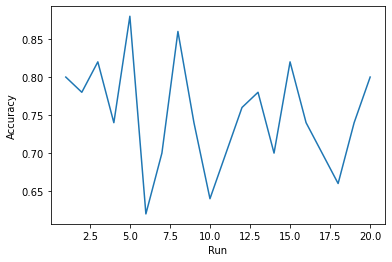

In [293]:
# Plot the results
x = np.arange(1, runs+1)
y = average
plt.plot(x, y)
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.show()